In [ ]:
import pandas as pd
import numpy as num

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings
from sklearn.metrics import classification_report,accuracy_score,roc_curve,auc
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
#fetch file from s3 bucket
import boto3

# When running on SageMaker, need execution role
from sagemaker import get_execution_role
role = get_execution_role()

# Declare bucket name, remote file, and destination
my_bucket = 'smarthome-ids'
orig_file = 'IoT Intrusion Dataset 2020.csv'
dest_file = 'df'

# Connect to S3 bucket and download file
s3 = boto3.resource('s3')
s3.Bucket(my_bucket).download_file(orig_file, dest_file)

Text(0.5, 0, 'category')

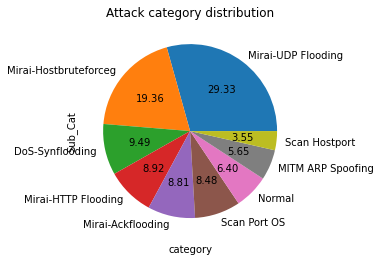

In [ ]:
dest_file='IoT Intrusion Dataset 2020.csv'
df = pd.read_csv(dest_file, delimiter=',')
#pd.options.display.float_format = '{:.0f}'.format

#df.columns = ["Src_IP", "Dst_IP", "Protocol", "Cat", "Idle_Mean","Flow_Pkts" "Sub_Cat", "Label"]

classes = pd.value_counts(df["Sub_Cat"], sort = True)

classes.plot(kind = 'pie', rot=0,autopct="%0.2f")
plt.title("Attack category distribution")

plt.xlabel("category")

In [ ]:
df['Label'].replace('Normal',0,inplace=True)
df['Label'].replace('Anomaly',1,inplace=True)

In [ ]:
#one-hot encoder for categorical values
df_enc=pd.get_dummies(df,columns=['Sub_Cat'])

In [ ]:
df_enc

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Cat,Sub_Cat_DoS-Synflooding,Sub_Cat_MITM ARP Spoofing,Sub_Cat_Mirai-Ackflooding,Sub_Cat_Mirai-HTTP Flooding,Sub_Cat_Mirai-Hostbruteforceg,Sub_Cat_Mirai-UDP Flooding,Sub_Cat_Normal,Sub_Cat_Scan Hostport,Sub_Cat_Scan Port OS
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,Mirai,0,0,1,0,0,0,0,0,0
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,DoS,1,0,0,0,0,0,0,0,0
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,Scan,0,0,0,0,0,0,0,0,1
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,Mirai,0,0,0,0,1,0,0,0,0
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,Mirai,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,Mirai,0,0,0,0,0,1,0,0,0
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,DoS,1,0,0,0,0,0,0,0,0
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,Scan,0,0,0,0,0,0,0,0,1
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,Normal,0,0,0,0,0,0,1,0,0


In [ ]:
#target variables
y=df_enc.iloc[:,[85,86,87,88,89,90,91,92,93]]

In [ ]:
#feature names
class_labels=df['Sub_Cat'].unique()
class_labels

array(['Mirai-Ackflooding', 'DoS-Synflooding', 'Scan Port OS',
       'Mirai-Hostbruteforceg', 'Mirai-UDP Flooding',
       'Mirai-HTTP Flooding', 'Normal', 'Scan Hostport',
       'MITM ARP Spoofing'], dtype=object)

In [ ]:
X=df.drop(['Label','Src_IP', 'Sub_Cat', 'Timestamp', 'Flow_ID', 'Cat', 'Dst_IP','Src_Port','Dst_Port','Protocol','Flow_Byts/s','Flow_Pkts/s'],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
# Choose your test size to split between training and testing sets:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
## Label encoding
y_train = y_train.to_numpy(dtype=num.int64)
y_test = y_test.to_numpy(dtype=num.int64)

In [ ]:
from sklearn.manifold import tsne
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection")


ImportError: cannot import name 'tsne' from 'sklearn.manifold' (C:\Users\Bhuvana Janita\anaconda3\lib\site-packages\sklearn\manifold\__init__.py)

In [ ]:
%conda install -c conda-forge xgboost


Note: you may need to restart the kernel to use updated packages.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: xgboost


In [ ]:
#XGBoost + OneVsRestClassifier
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

xgb = XGBClassifier(tree_method='hist',
                    predictor='auto',
                    random_state=0, n_jobs=-1)

ovr_clf = OneVsRestClassifier(estimator=xgb, n_jobs=-1)

y_score = ovr_clf.fit(x_train, y_train)
ovr_probs = ovr_clf.predict_proba(x_test)

log_loss(y_test, ovr_probs)

0.6954212171783194

In [ ]:
ovr_probs

array([[1.25432905e-07, 5.86969581e-05, 1.01973746e-05, ...,
        1.19762117e-04, 1.00453335e-05, 4.32045963e-05],
       [1.96767542e-06, 1.38730195e-03, 1.50166266e-03, ...,
        1.24224302e-04, 2.50381476e-04, 3.41409090e-04],
       [1.68628958e-06, 1.03316468e-03, 1.49797148e-03, ...,
        5.14689091e-05, 2.48048163e-04, 6.99587748e-04],
       ...,
       [1.66328221e-06, 1.56544604e-06, 3.21805835e-01, ...,
        5.50133836e-06, 4.11273419e-07, 1.05586480e-06],
       [3.83668635e-07, 6.96383665e-07, 1.82749329e-06, ...,
        3.03981028e-06, 1.23153109e-06, 2.72893112e-06],
       [1.02148670e-06, 4.10141349e-01, 2.54400671e-02, ...,
        1.80015212e-03, 1.16785867e-02, 4.93517704e-02]], dtype=float32)

In [ ]:
n_classes = y.shape[1]
n_classes

9

In [ ]:
y


,Sub_Cat_DoS-Synflooding,Sub_Cat_MITM ARP Spoofing,Sub_Cat_Mirai-Ackflooding,Sub_Cat_Mirai-HTTP Flooding,Sub_Cat_Mirai-Hostbruteforceg,Sub_Cat_Mirai-UDP Flooding,Sub_Cat_Normal,Sub_Cat_Scan Hostport,Sub_Cat_Scan Port OS
0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
625778,0,0,0,0,0,1,0,0,0
625779,1,0,0,0,0,0,0,0,0
625780,0,0,0,0,0,0,0,0,1
625781,0,0,0,0,0,0,1,0,0


In [ ]:
y.describe()

,Sub_Cat_DoS-Synflooding,Sub_Cat_MITM ARP Spoofing,Sub_Cat_Mirai-Ackflooding,Sub_Cat_Mirai-HTTP Flooding,Sub_Cat_Mirai-Hostbruteforceg,Sub_Cat_Mirai-UDP Flooding,Sub_Cat_Normal,Sub_Cat_Scan Hostport,Sub_Cat_Scan Port OS
count,625783.000000,625783.000000,625783.000000,625783.000000,625783.000000,625783.000000,625783.000000,625783.000000,625783.000000
mean,0.094907,0.056532,0.088088,0.089197,0.193647,0.293319,0.064037,0.035463,0.084811
std,0.293086,0.230947,0.283423,0.285028,0.395156,0.455284,0.244818,0.184947,0.278600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
class_names=y.columns

In [ ]:
class_names

Index(['Sub_Cat_DoS-Synflooding', 'Sub_Cat_MITM ARP Spoofing',
       'Sub_Cat_Mirai-Ackflooding', 'Sub_Cat_Mirai-HTTP Flooding',
       'Sub_Cat_Mirai-Hostbruteforceg', 'Sub_Cat_Mirai-UDP Flooding',
       'Sub_Cat_Normal', 'Sub_Cat_Scan Hostport', 'Sub_Cat_Scan Port OS'],
      dtype='object')

<ipython-input-24-522c17f29eef>:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


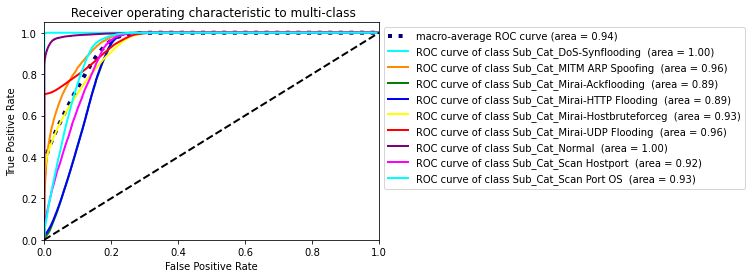

In [ ]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
from scipy import interp
from itertools import cycle
lw=2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ovr_probs[:,i])
     roc_auc[i] = auc(fpr[i], tpr[i])



# First aggregate all false positive rates
all_fpr = num.unique(num.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = num.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'green','blue','yellow','red','purple','magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}  (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
!pip install xgboost

In [ ]:
#XGBoost + MultiOutputClassifier
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

xgb = XGBClassifier(tree_method='hist',
                    predictor='auto',
                    random_state=0, n_jobs=-1)

mo_clf = MultiOutputClassifier(estimator=xgb, n_jobs=-1)

mo_clf.fit(x_train, y_train)

mo_probs = mo_clf.predict_proba(x_test)

n_classes = y_test.shape[1]
n_test_samples = x_test.shape[0]
mo_probs_pos = num.zeros((n_test_samples, n_classes))

for c in range(n_classes):
    c_probs = mo_probs[c]
    mo_probs_pos[:, c] = c_probs[:, 1]

log_loss(y_test, mo_probs_pos)

0.6954212241811231

In [ ]:
#XGBoost + ClassifierChain
from sklearn.multioutput import ClassifierChain
from joblib import Parallel, delayed
import timeit

chains = [ClassifierChain(base_estimator=xgb, order='random')
          for i in range(5)]

chains = Parallel(n_jobs=-1)(delayed(chain.fit)(x_train, y_train) for chain in chains)

chains_ensemble_proba = Parallel(n_jobs=-1)(delayed(chain.predict_proba)(x_test) for chain in chains)

log_loss(y_test, num.array(chains_ensemble_proba).mean(axis=0))

0.7471020708863754

In [ ]:
%conda install -c conda-forge imbalanced-learn

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::imageio==2.9.0=py_0
  - conda-forge/linux-64::jupyter_server==1.4.1=py36h5fab9bb_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::bokeh==2.2.3=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/noarch::aiobotocore==1.2.1=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-spyder==0.3.2=pyhd8ed1ab_0
  - conda-forge/linux-64::anyio==2.1.0=py36h5fab9bb_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib-base==3.3.4=py36hd391965_0
  - conda-forge/linux-64::spyder==4.2.0=py36h5fab9bb_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::sphinx==3.5.1=pyhd8ed1ab_0
  - conda-

In [ ]:
#rf and balanced random forest
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier


rf = RandomForestClassifier(n_estimators=50, random_state=0)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0,class_weight='balanced')

mo_rf = MultiOutputClassifier(estimator=rf, n_jobs=-1)
mo_brf = MultiOutputClassifier(estimator=brf, n_jobs=-1)

mo_rf.fit(x_train, y_train)
mo_brf.fit(x_train, y_train)


y_pred_rf = mo_rf.predict(x_test)
y_pred_brf =mo_brf.predict(x_test)


In [ ]:
from sklearn.metrics import log_loss
rf_probs = mo_rf.predict_proba(x_test)

n_classes = y_test.shape[1]
n_test_samples = x_test.shape[0]
rf_probs_pos = num.zeros((n_test_samples, n_classes))

for c in range(n_classes):
    c_probs = rf_probs[c]
    rf_probs_pos[:, c] = c_probs[:, 1]
    
log_loss(y_test,rf_probs_pos)

1.3901934518167092

In [ ]:
from sklearn.metrics import log_loss
brf_probs=mo_brf.predict_proba(x_test)

n_classes = y_test.shape[1]
n_test_samples = x_test.shape[0]
brf_probs_pos = num.zeros((n_test_samples, n_classes))

for c in range(n_classes):
    c_probs = brf_probs[c]
    brf_probs_pos[:, c] = c_probs[:, 1]

log_loss(y_test,brf_probs_pos)

0.8077775823363825

In [ ]:
#random forest
from sklearn.metrics import classification_report
print("\t\t\tRandom Forest")
print(classification_report(y_test, mo_rf.predict(x_test),target_names=class_labels))


			Random Forest
                       precision    recall  f1-score   support

    Mirai-Ackflooding       1.00      1.00      1.00     15107
      DoS-Synflooding       0.67      0.43      0.53      8707
         Scan Port OS       0.09      0.02      0.03     13656
Mirai-Hostbruteforceg       0.14      0.03      0.05     13994
   Mirai-UDP Flooding       0.80      0.52      0.63     30268
  Mirai-HTTP Flooding       0.92      0.71      0.80     45766
               Normal       0.97      0.86      0.91      9937
        Scan Hostport       0.50      0.07      0.13      5615
    MITM ARP Spoofing       0.48      0.17      0.25     13396

            micro avg       0.82      0.50      0.62    156446
            macro avg       0.62      0.42      0.48    156446
         weighted avg       0.70      0.50      0.57    156446
          samples avg       0.50      0.50      0.50    156446



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Balanced random forest
from sklearn.metrics import classification_report
print("\tBalanced Random Forest")
print(classification_report(y_test, mo_brf.predict(x_test),target_names=class_labels))

	Balanced Random Forest
                       precision    recall  f1-score   support

    Mirai-Ackflooding       1.00      1.00      1.00     15107
      DoS-Synflooding       0.21      0.98      0.35      8707
         Scan Port OS       0.29      0.99      0.45     13656
Mirai-Hostbruteforceg       0.30      0.99      0.46     13994
   Mirai-UDP Flooding       0.48      0.97      0.64     30268
  Mirai-HTTP Flooding       0.61      0.94      0.74     45766
               Normal       0.43      0.98      0.60      9937
        Scan Hostport       0.14      0.97      0.25      5615
    MITM ARP Spoofing       0.34      0.97      0.50     13396

            micro avg       0.40      0.97      0.57    156446
            macro avg       0.42      0.98      0.55    156446
         weighted avg       0.49      0.97      0.63    156446
          samples avg       0.59      0.97      0.67    156446



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#XGBoost with Multioutput classifier
from sklearn.metrics import classification_report
print("\t\tXGBoost with Multioutput classifier")
print(classification_report(y_test, mo_clf.predict(x_test),target_names=class_labels))

		XGBoost with Multioutput classifier
                       precision    recall  f1-score   support

    Mirai-Ackflooding       1.00      1.00      1.00     15107
      DoS-Synflooding       0.78      0.37      0.50      8707
         Scan Port OS       0.75      0.01      0.02     13656
Mirai-Hostbruteforceg       0.87      0.03      0.05     13994
   Mirai-UDP Flooding       0.84      0.46      0.60     30268
  Mirai-HTTP Flooding       1.00      0.70      0.83     45766
               Normal       0.99      0.86      0.92      9937
        Scan Hostport       0.80      0.05      0.10      5615
    MITM ARP Spoofing       0.62      0.08      0.15     13396

            micro avg       0.94      0.48      0.64    156446
            macro avg       0.85      0.40      0.46    156446
         weighted avg       0.88      0.48      0.56    156446
          samples avg       0.48      0.48      0.48    156446



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#XGBoost with OVR classifier
from sklearn.metrics import classification_report
print("\t\tXGBoost with OVR classifier")
print(classification_report(y_test, ovr_clf.predict(x_test),target_names=class_labels))

		XGBoost with OVR classifier
                       precision    recall  f1-score   support

    Mirai-Ackflooding       1.00      1.00      1.00     15107
      DoS-Synflooding       0.78      0.37      0.50      8707
         Scan Port OS       0.75      0.01      0.02     13656
Mirai-Hostbruteforceg       0.87      0.03      0.05     13994
   Mirai-UDP Flooding       0.84      0.46      0.60     30268
  Mirai-HTTP Flooding       1.00      0.70      0.83     45766
               Normal       0.99      0.86      0.92      9937
        Scan Hostport       0.80      0.05      0.10      5615
    MITM ARP Spoofing       0.62      0.08      0.15     13396

            micro avg       0.94      0.48      0.64    156446
            macro avg       0.85      0.40      0.46    156446
         weighted avg       0.88      0.48      0.56    156446
          samples avg       0.48      0.48      0.48    156446



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
